**We would like to acknowledge Stanford University's CS231n on which we based the development of this project.**

In [1]:
USE_COLAB = False

import sys
import os

if USE_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # project folder, e.g. '239AS.2/project1/gan'
    FOLDERNAME = None
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    %cd /content/drive/My\ Drive/$FOLDERNAME


# You can use os.listdir() to find the folder
# Google drive is...weird.
print('cwd', os.getcwd())

cwd /Users/benji/Desktop/ECE-239AS/Project1/gan


TO FIND YOUR FILES IN COLAB:

Click the folder on the left sidebar
(content->)drive->MyDrive->WhereverYouPutTheseFiles

Double clicking gan.py will open an editor on the right.

## Enabling GPU:
Runtime > Change runtime type > Hardware accelerator: select T4 GPU or v2-8 TPU. You may run out of compute allowance at some point.
**When you will be away for a long period of time, select Runtime->Disconnect and delete runtime! Make sure to preserve your compute allowance!**

# Generative Adversarial Networks (GANs)

In C147/C247, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Here's an example of what your outputs from the 3 different models you're going to train should look like. Note that GANs are sometimes finicky, so your outputs might not look exactly like this. This is just meant to be a *rough* guideline of the kind of quality you can expect:

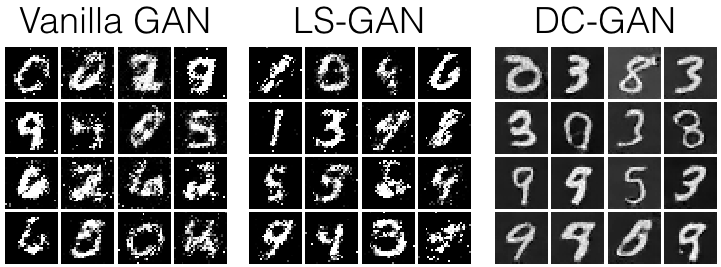

In [2]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('nndl2/gan_outputs.png')

In [3]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from gan import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('nndl2/gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(dtype)

<class 'torch.FloatTensor'>


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST`.

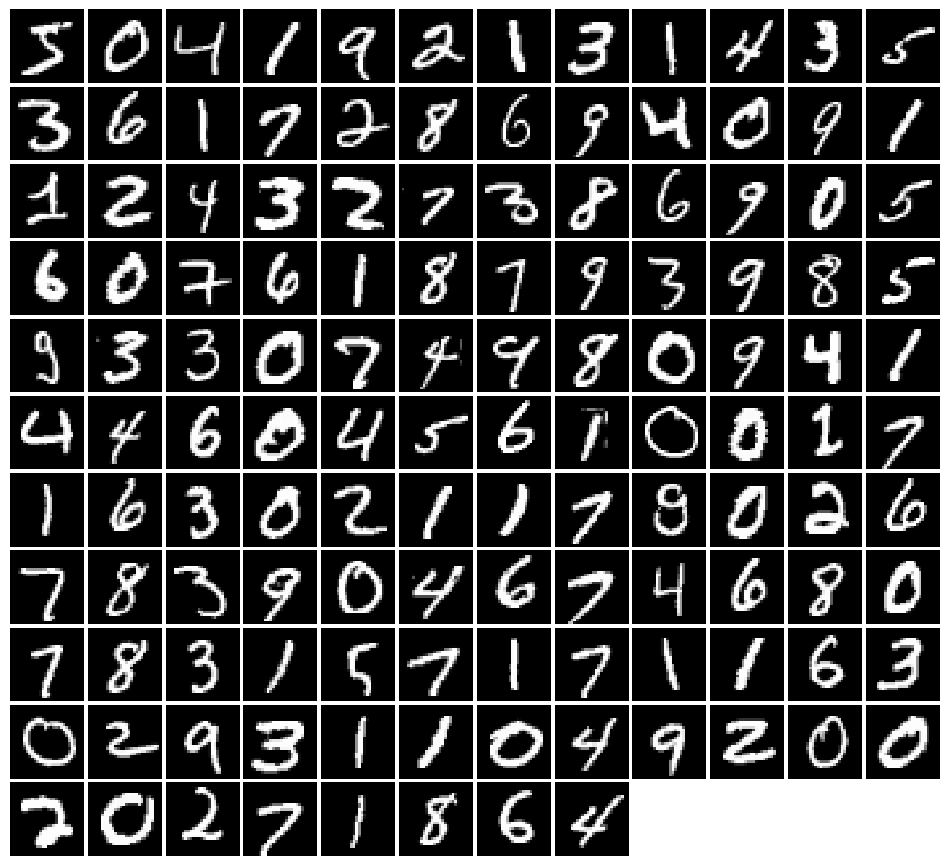

In [4]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './nndl2',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './nndl2',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise (1 point)
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `gan.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

In [5]:
from gan import sample_noise

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


## Flatten

We provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [6]:
from gan import Flatten, Unflatten, initialize_weights

# Discriminator (1 point)
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Implement `discriminator` in `gan.py`

Test to make sure the number of parameters in the discriminator is correct:

In [7]:
from gan import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


# Generator (1 point)
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

All fully connected layers should include bias terms. Implement `generator` in `gan.py`

Test to make sure the number of parameters in the generator is correct:

In [8]:
from gan import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss (2 points)

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation that relies on PyTorch's `nn.BCEWithLogitsLoss`.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable for compatibility with BCEWithLogitsLoss, which uses floating point data types.


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch. This is taken care of in `bce_loss` which combines the loss by averaging. **Hint**: Do NOT concatenate real and fake losses. Sum the two (empirical) expectations instead.

Implement `discriminator_loss` and `generator_loss` in `gan.py`

Test your generator and discriminator loss. You should see errors < 1e-7.

In [9]:
from gan import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 3.97058e-09


In [10]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing Our Loss (1 point)
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

Implement `get_optimizer` in `gan.py`

# Training a GAN!

We provide you the main training loop. You won't need to change `run_a_gan` in `gan.py`, but we encourage you to read through it for your own understanding. If you train with the CPU, it takes about 7 minutes. If you train with the T4 GPU, it takes about 1 minute and 30 seconds.

If it doesn't work the first time, check the discriminator: Did you use Flatten()?

In [11]:
from gan import get_optimizer, run_a_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.328, G:0.7202
Iter: 250, D: 1.708, G:1.212
Iter: 500, D: 1.24, G:1.197
Iter: 750, D: 1.543, G:0.8584
Iter: 1000, D: 1.115, G:1.018
Iter: 1250, D: 1.28, G:0.9009
Iter: 1500, D: 1.166, G:1.422
Iter: 1750, D: 1.153, G:1.055
Iter: 2000, D: 1.32, G:0.7466
Iter: 2250, D: 1.317, G:1.804
Iter: 2500, D: 1.422, G:0.96
Iter: 2750, D: 1.331, G:0.8434
Iter: 3000, D: 1.316, G:0.8534
Iter: 3250, D: 1.315, G:0.9213
Iter: 3500, D: 1.372, G:0.9194
Iter: 3750, D: 1.234, G:0.922


Run the cell below to show the generated images.

Iter: 0


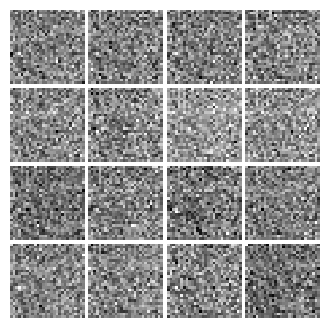


Iter: 250


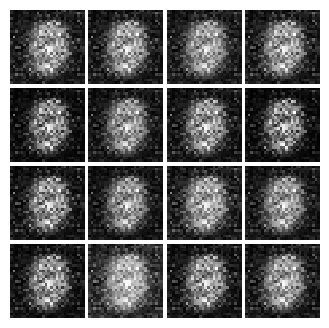


Iter: 500


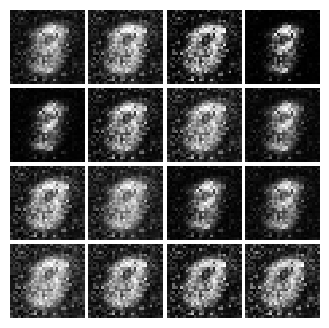


Iter: 750


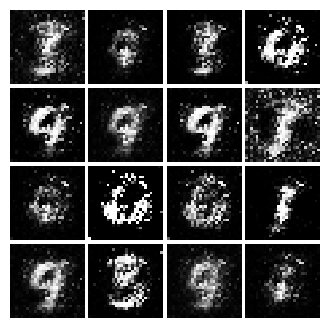


Iter: 1000


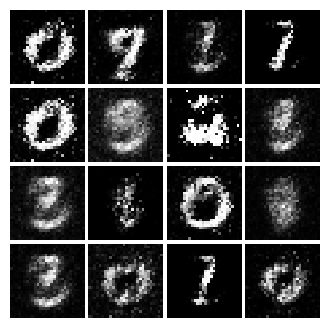


Iter: 1250


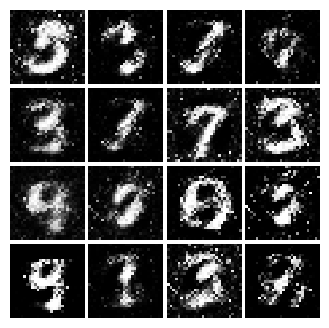


Iter: 1500


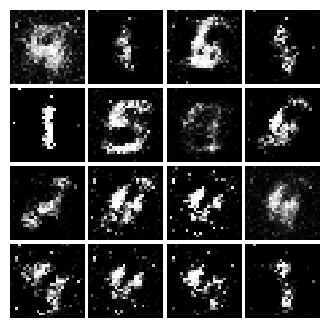


Iter: 1750


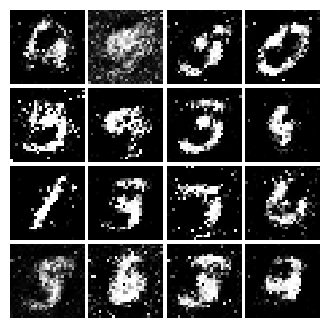


Iter: 2000


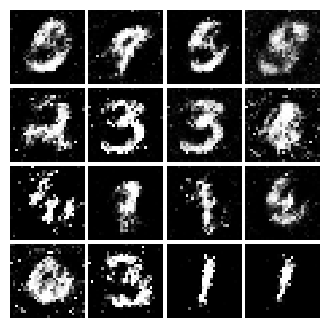


Iter: 2250


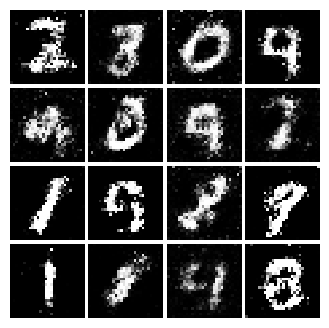


Iter: 2500


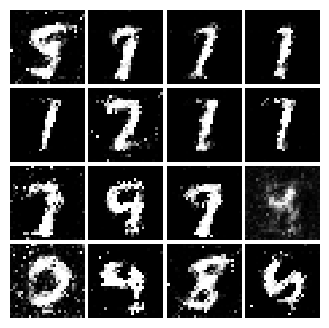


Iter: 2750


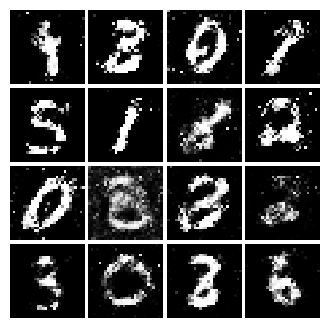


Iter: 3000


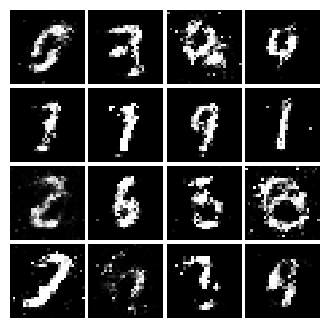


Iter: 3250


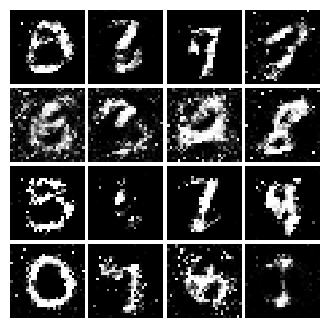


Iter: 3500


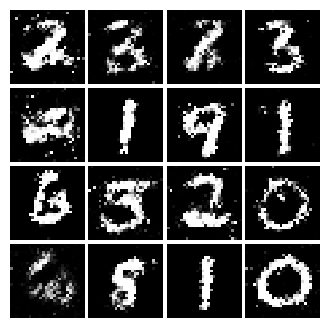


Iter: 3750


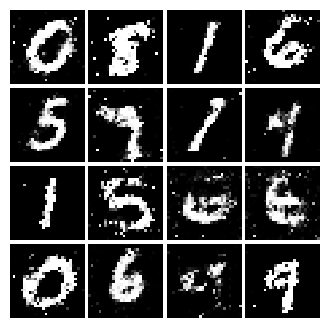

In [12]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 1

What does your final vanilla GAN image look like?

Vanilla GAN final image:


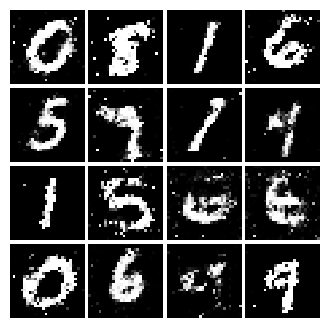

In [13]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN (2 points)
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`). **If** you get errors of 0.333..., you probably forgot to include the 1/2 term.

Implement `ls_discriminator_loss`, `ls_generator_loss` in `gan.py`

Before running a GAN with our new loss function, let's check it:

In [14]:
from gan import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.64377e-08
Maximum error in g_loss: 3.36961e-08


Run the following cell to train your model! If you train with the CPU, it takes about 7 minutes. If you train with the T4 GPU, it takes about 1 minute and 30 seconds.

In [15]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.5689, G:0.51
Iter: 250, D: 0.1907, G:0.4398
Iter: 500, D: 0.06536, G:0.6293
Iter: 750, D: 0.2833, G:0.4532
Iter: 1000, D: 0.1774, G:0.2748
Iter: 1250, D: 0.1591, G:0.2286
Iter: 1500, D: 0.1747, G:0.2404
Iter: 1750, D: 0.2421, G:0.1856
Iter: 2000, D: 0.2288, G:0.1982
Iter: 2250, D: 0.2421, G:0.1728
Iter: 2500, D: 0.2275, G:0.1794
Iter: 2750, D: 0.2221, G:0.161
Iter: 3000, D: 0.2357, G:0.1436
Iter: 3250, D: 0.234, G:0.1512
Iter: 3500, D: 0.2465, G:0.1435
Iter: 3750, D: 0.2289, G:0.1495


Run the cell below to show generated images.

Iter: 0


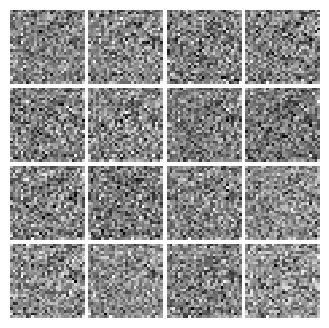


Iter: 250


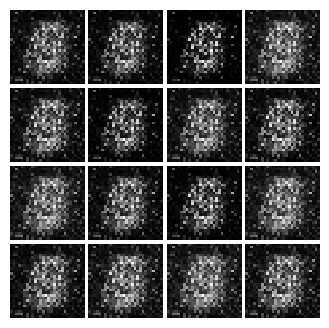


Iter: 500


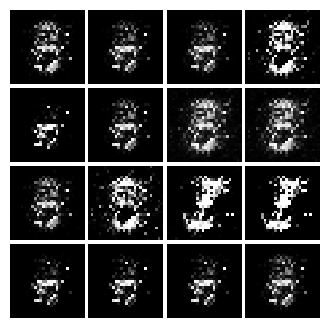


Iter: 750


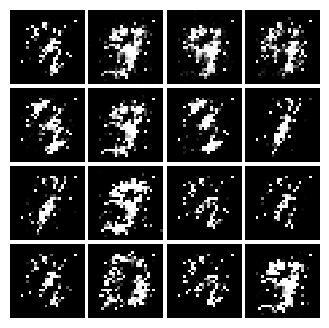


Iter: 1000


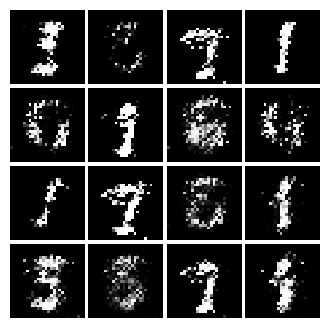


Iter: 1250


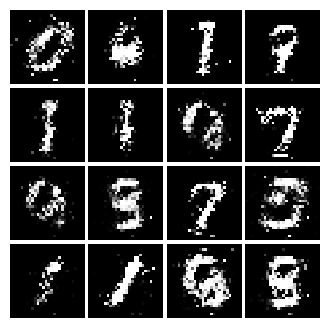


Iter: 1500


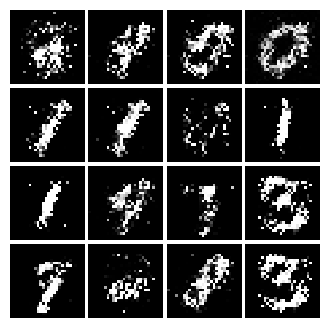


Iter: 1750


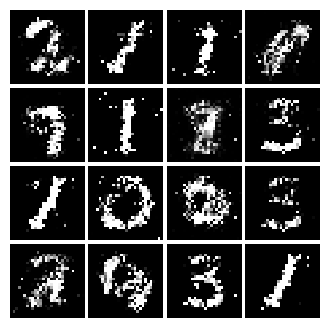


Iter: 2000


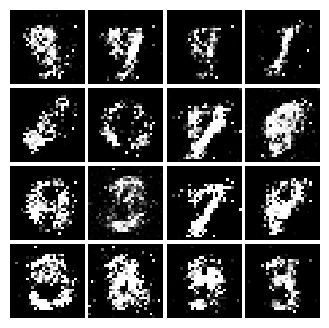


Iter: 2250


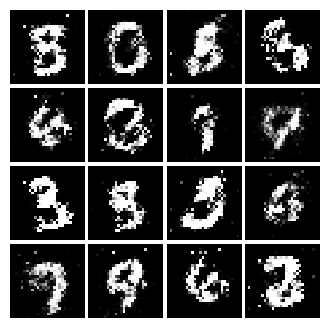


Iter: 2500


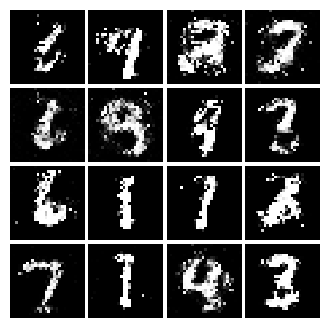


Iter: 2750


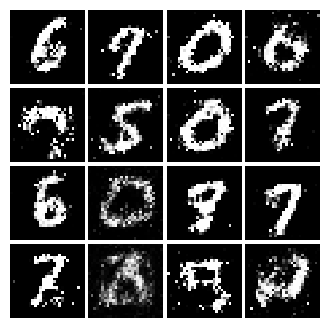


Iter: 3000


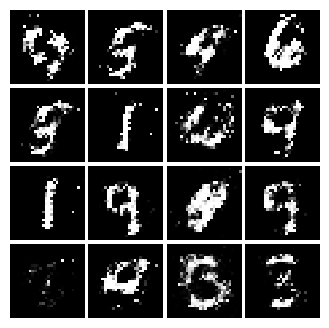


Iter: 3250


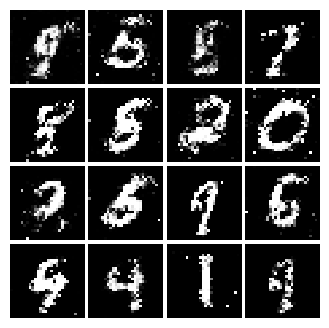


Iter: 3500


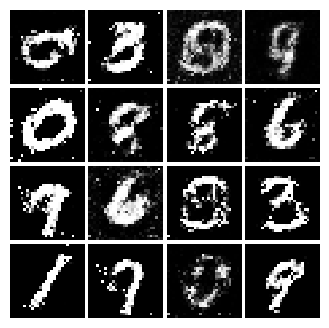


Iter: 3750


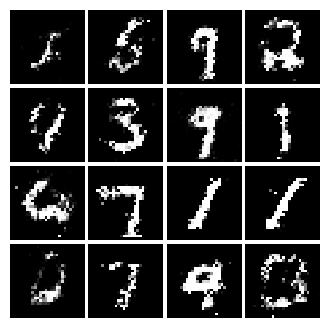

In [16]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 2

What does your final LSGAN image look like?

LSGAN final image:


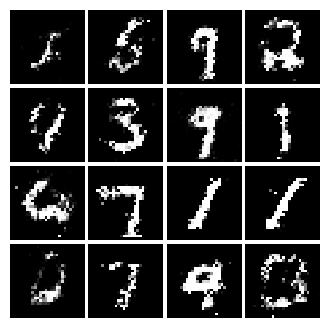

In [17]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deep Convolutional GAN (2 points)
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. **Hint**: There is no need to specify padding. **Warning**: If you use LazyLinear I will take off points.
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier` in `gan.py`

In [25]:
from gan import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [26]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in classifier. Check your achitecture.')
    else:
        print('Correct number of parameters in classifier.')

test_dc_classifer()

Correct number of parameters in classifier.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We are always "training" in GAN mode.
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Use `Unflatten()` to reshape into Image Tensor of shape 7, 7, 128
* `ConvTranspose2d`: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* `ConvTranspose2d`: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (using `Flatten()`)

Implement `build_dc_generator` in `gan.py`

In [27]:
from gan import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [28]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


Run the following cell to train your DCGAN. If you train with the CPU, it takes about 35 minutes. If you train with the T4 GPU, it takes about 1 minute.

In [29]:
D_DC = build_dc_classifier().type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

Iter: 0, D: 1.404, G:0.5817
Iter: 250, D: 1.761, G:0.8128
Iter: 500, D: 1.188, G:1.007
Iter: 750, D: 1.184, G:1.344
Iter: 1000, D: 1.346, G:0.8446
Iter: 1250, D: 1.281, G:0.8987
Iter: 1500, D: 1.113, G:0.9767
Iter: 1750, D: 1.138, G:0.9521


Run the cell below to show generated images.

Iter: 0


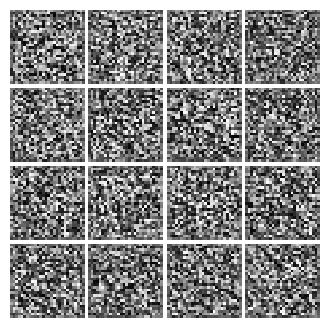


Iter: 250


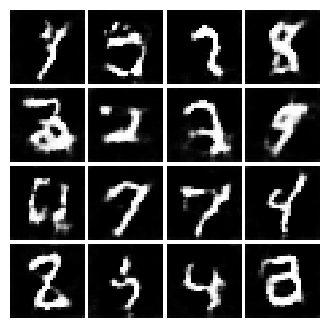


Iter: 500


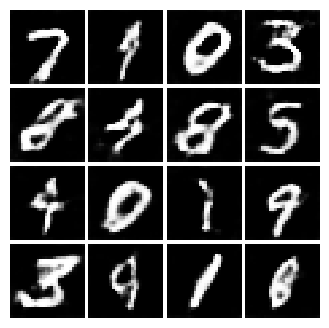


Iter: 750


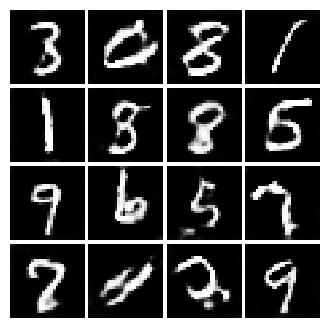


Iter: 1000


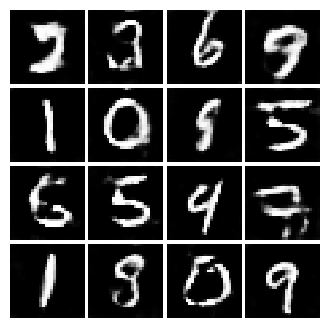


Iter: 1250


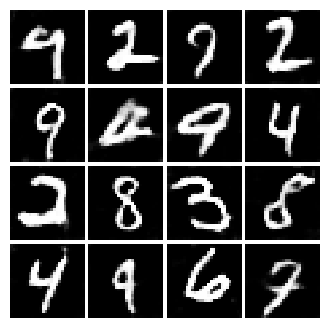


Iter: 1500


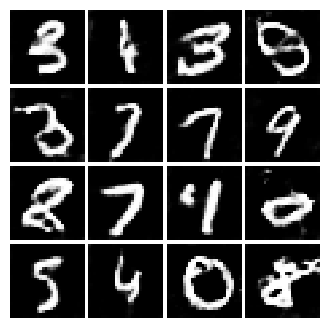


Iter: 1750


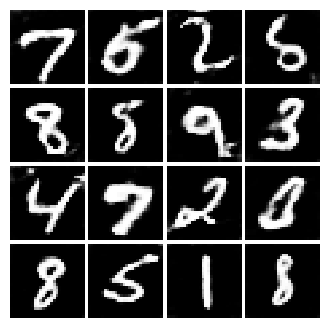

In [30]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 3

What does your final DCGAN image look like?

DCGAN final image:


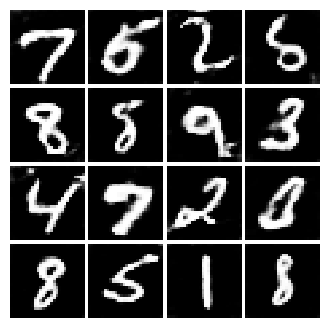

In [31]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

## Inline Question 4 (1 point)

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$,
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below and briefly explain what $f(x,y)$ evaluates to.

### Your answer:


| $y_0$  | $y_1$  | $y_2$  | $y_3$  | $y_4$  | $y_5$  | $y_6$  |
| :----- | :----- | :----- | :----- | :----- | :----- | :----- |
|   1    | 2   | 1   | -1   | -2   | -1   | 1   |
| $x_0$  | $x_1$  | $x_2$  | $x_3$  | $x_4$  | $x_5$  | $x_6$  |
|   1    | -1   | -2   | -1   | 1   | 2   | 1   |
| $f(x_0,y_0)$  | $f(x_1,y_1)$  | $f(x_2,y_2)$  | $f(x_3,y_3)$ | $f(x_4,y_4)$  | $f(x_5,y_5)$  | $f(x_6,y_6)$  |
|   1    | -2   | -2   | 1   | -2   | -2   | 1   |

For the first part, $\min_x\max_y f(x,y)$ should ideally evaluate to 0. The maximum value of
y for this function would be positive or negative $\infty$ depending on whether x is positive or
negative respectively but the minimum value of x that we could choose would be 0 which
means $\min_x\max_y f(x,y)$ would have to evaluate to 0. Using alternating gradients, we
can see that the value oscillates around 0 and does not converge and seems like the
table would repeat the similar values.

## Inline Question 5 (1 point)
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:

No we would no reach the optimal value of 0. This happens because of the method of
alternating gradient steps which would make the values of x and y update in a way that
would undo the progress of the previous update. This is why we would see oscillations
as the values od x and y are constantly in a loop of the same values. We can also look at
the shape of the function and examine it graphically to see that the method of
alternating gradients would never reach the optimal value of (0,0)


## Inline Question 6 (1 point)
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer:
No this seems to not be a good sign. If generator loss is decreasing while the
discriminator loss is constant, the discriminator is not learning and can't actually
discrminate between good and bad images and the generator isn't actually creating
great images, it is simply going up against a bad discrminator and the generator won't
learn well.
